In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


## Question 1 & 2

Given data about an instrumental variable, find the effect. X is the treatment, W the confounder, Y the outcome, and Z the instrument. Use homework_4.1.csv. 

In [6]:
df_4_1 = pd.read_csv('homework_4.1.csv')



Subtract the average ﻿Y﻿ value for ﻿Z equals 1﻿ and ﻿Z equals 0﻿. Subtract the average ﻿X﻿ value for ﻿Z equals 1﻿ and ﻿Z equals 0﻿. Divide the two. 

In [7]:
avg_y_z1 = df_4_1[df_4_1['Z'] == 1]['Y'].mean()
avg_y_z0 = df_4_1[df_4_1['Z'] == 0]['Y'].mean()
avg_x_z1 = df_4_1[df_4_1['Z'] == 1]['X'].mean()
avg_x_z0 = df_4_1[df_4_1['Z'] == 0]['X'].mean()

# Apply formula
result = (avg_y_z1 - avg_y_z0) / (avg_x_z1 - avg_x_z0)
print("Result:", result)

Result: 1.5618587073955674


Find the average ﻿Y﻿ value for ﻿Z equals 1﻿ and ﻿Z equals 0﻿ for a narrow range of ﻿W﻿. Find the average ﻿X﻿ value for ﻿Z equals 1﻿ and ﻿Z equals 0﻿ for the same narrow range of ﻿W﻿. Take the ratio to find the effect. Then average this over all the ranges of ﻿W﻿. 


In [8]:
data_sorted_4_4 = df_4_1.sort_values("W")
num_bins = 5  # You can adjust the granularity
data_sorted_4_4["W_bin"] = pd.qcut(data_sorted_4_4["W"], q=num_bins, duplicates='drop')

# Container for local effects
local_effects_4_1 = []

# Loop over each bin
for bin_label, group in data_sorted_4_4.groupby("W_bin", observed=True):
    z1 = group[group["Z"] == 1]
    z0 = group[group["Z"] == 0]

    # Only proceed if both Z=1 and Z=0 are present in the bin
    if len(z1) > 0 and len(z0) > 0:
        avg_y_diff = z1["Y"].mean() - z0["Y"].mean()
        avg_x_diff = z1["X"].mean() - z0["X"].mean()

        # Avoid divide by zero
        if avg_x_diff != 0:
            local_effects_4_1.append(avg_y_diff / avg_x_diff)

# Final estimate: average of local effects
final_effect_4_1 = np.mean(local_effects_4_1)
print("Estimated Effect (Average over W bins):", final_effect_4_1)

Estimated Effect (Average over W bins): 1.5156437668382101


## Question 3-5

Given student data involving test scores (﻿X﻿), a cutoff, and an outcome (Y), which measures whether the students got into college (as in the example in the text), determine whether the math course helps students get into college in each dataset. Use datasets homework_4.2.a and homework_4.2.b. 

In [10]:
df_4_2_a = pd.read_csv('homework_4.2.a.csv')
df_4_2_b = pd.read_csv('homework_4.2.b.csv')

In [17]:
def plot_rdd(data, cutoff=80, x_col='X', y_col='Y'):
    """
    Plot regression discontinuity and fit separate linear models before and after the cutoff.

    Parameters:
        data (pd.DataFrame): DataFrame with columns for the running variable and outcome.
        cutoff (float): The cutoff value for the running variable.
        x_col (str): Column name for the running variable.
        y_col (str): Column name for the outcome variable.

    Returns:
        model_below, model_above: Fitted OLS models for below and above cutoff.
    """
    # Create a "running variable" centered at cutoff
    data = data.copy()
    data['X_centered'] = data[x_col] - cutoff
    data['above_cutoff'] = (data[x_col] >= cutoff).astype(int)

    # Separate datasets for before and after the cutoff
    data_below = data[data[x_col] < cutoff]
    data_above = data[data[x_col] >= cutoff]

    # Fit separate linear models before and after the cutoff
    X_below = sm.add_constant(data_below['X_centered'])
    model_below = sm.OLS(data_below[y_col], X_below).fit()

    X_above = sm.add_constant(data_above['X_centered'])
    model_above = sm.OLS(data_above[y_col], X_above).fit()

    print("Slope before cutoff:", model_below.params['X_centered'])
    print("Slope after cutoff:", model_above.params['X_centered'])

    # Plot for visualization
    plt.scatter(data[x_col], data[y_col], alpha=0.5, label='Data')

    # Plot regression lines
    x_vals_below = data_below['X_centered']
    y_vals_below = model_below.predict(sm.add_constant(x_vals_below))
    plt.plot(data_below[x_col], y_vals_below, color='red', label='Below cutoff fit')

    x_vals_above = data_above['X_centered']
    y_vals_above = model_above.predict(sm.add_constant(x_vals_above))
    plt.plot(data_above[x_col], y_vals_above, color='green', label='Above cutoff fit')

    plt.axvline(cutoff, color='black', linestyle='--', label='Cutoff')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title("Regression Discontinuity around Cutoff")
    plt.legend()
    plt.show()

    return model_below, model_above

Slope before cutoff: 0.0002238307970367562
Slope after cutoff: 0.00016108686482243465


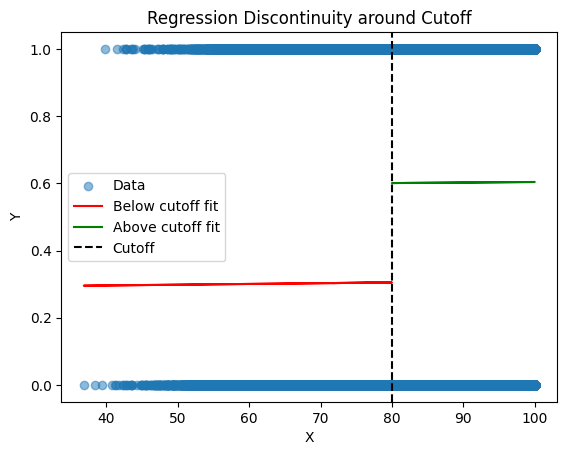

In [20]:
below_4_2_a, above_4_2_a = plot_rdd(df_4_2_a, cutoff=80)

In [21]:
print("BELOW cutoff:")
print(below_4_2_a.summary())
print("\nABOVE cutoff:")
print(above_4_2_a.summary())

BELOW cutoff:
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4305
Date:                Sat, 14 Jun 2025   Prob (F-statistic):              0.512
Time:                        10:25:49   Log-Likelihood:                -32034.
No. Observations:               49926   AIC:                         6.407e+04
Df Residuals:                   49924   BIC:                         6.409e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3050      0.003     8

Slope before cutoff: 0.010216711274456681
Slope after cutoff: 0.005008614068236671


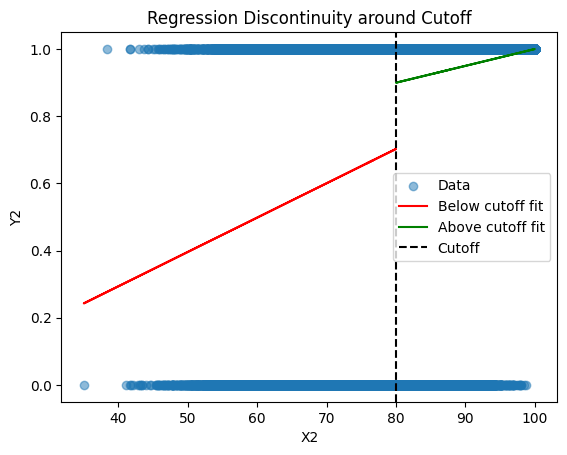

In [ ]:
below_4_2_b, above_4_2_b = plot_rdd(df_4_2_b, cutoff=80, x_col='X2', y_col='Y2')

In [22]:
print("BELOW cutoff:")
print(below_4_2_b.summary())
print("\nABOVE cutoff:")
print(above_4_2_b.summary())

BELOW cutoff:
                            OLS Regression Results                            
Dep. Variable:                     Y2   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     679.6
Date:                Sat, 14 Jun 2025   Prob (F-statistic):          8.07e-149
Time:                        10:26:18   Log-Likelihood:                 723.91
No. Observations:               49932   AIC:                            -1444.
Df Residuals:                   49930   BIC:                            -1426.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8995      0.002    48